# Adversarial Examples

Goal: Show how images can be manipulated to fool a classifier. Describe:

TODOs:

1. White box vs black box. And cause classification to any class or a specific class!

2. Describe process of generating adversarial examples (loss function):

2.1 No constrain on loss function

2.2. Constrain loss function


3. Describe alternative attack method


4. Describe defenses against attacks. (ideas from SafetyNet fro example)

**Data**

Neural networks consistently misclassify adversarial examples. The same adversarial examples are classified ad the same clas by different models.


Get maybe 10 images



Experiments with adversarial examples as described in []. This notebook is losly based on ideas from the (PyTorch tutorial) [] on adversarial examples.

-----------------------------

**Motivation**

Neural networks are used in different vision tasks. Their strength lies ...

However, they can be fooled [a, b, c].


Neural networks consistently misclassify adversarial examples. The same adversarial examples are classified ad the same class by different models.

In this tutorial/ overview we show the effects of adversarial examples on googleNet. We show that examples generated using the Fast Gradient Attach [] we are able to fool the classifier to predict a wrong class at a high confidence. As a human we cannot tell the difference of the adversarial example and the origial example. We give a brief overview of other techniques to generate adversarial examples. At the end we present some common defenses against adversarial attacks.
_____________________________________________

**Attack Methods**

In general we differentiate between:
- White box attacks
- Black box attacks

[]



In [30]:
## Imports
import numpy as np
import pandas as pd

from PIL import Image
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets

import torch.nn.functional as F

import matplotlib.pyplot as plt

from torchvision import transforms
import urllib

plt.rcParams['figure.figsize'] = (20.0, 10.0)

## 1. Load data and model

First we load the model and data. We use the following.


### 1.1 Model

We use the trained googleNet [2]. It is available through the `Torchvision` library.

In [2]:
## Load model and data
model = models.googlenet(pretrained=True)
#model.load_state_dict("models/googlenet.pth")
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [3]:
def idx_to_name(idx):
    '''
    Converts the output class index from the googleNet to the respective name.
    
    Input:
    idx   -- Class index as integer
    
    Returns:
    names -- Class names corresponding to idx
    '''
    
    # Load dictionary from file
    names = {}
    with open("data/ImageNet/ImageNet_Classes_for_Humans.txt", "r") as f:
        for line in f:                            
            row = line.split()           
            key = row[0].replace(":", "")            
            val = row[1:]        
            names[int(key)] = val
    
    # Retrieve class name for idx
    name = names[idx] 
    
    return name

### 1.2 Data

We take a few examples from the ImageNet validation dataset [3]. We focus on the class `Panda` and download a few images.

In [93]:
## Function which takes a list of URLs and saves the images along with their label to the folder data/ImageNet

## Pick image at random, download ad return

def download_image(idx):
    '''
    Reads list of URLs, downloads the specified image and returns its local path.
    
    Inputs:
    idx          -- Index of the image from the list of URLs.
    
    Returns:
    filename     -- Path to the downloaded image
    '''
    
    ## Read URLs into a list
    urls = []
    with open("data/ImageNet/ImageNet_Panda.txt", "r") as f:
        for line in f:                            
            urls.append(line)
     
    ## Take class label
    #class_labels = "Giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca"
    class_labels = "panda"
    
    ## Pick image number idx for download
    url = urls[idx]
    filename = "./data/ImageNet/" + str(class_labels) + "/Image_" + str(idx) + ".jpg"
    try: 
        urllib.URLopener().retrieve(url, filename)
    
    except AttributeError:
        urllib.request.urlretrieve(url, filename)
            
    
    return filename

In [95]:
download_image(0)

A


'./data/ImageNet/panda/Image_0.jpg'

**Preprocess data**

To feed the image into the pretrained model, we need to preprocess it first. According to the [link](https://pytorch.org/docs/stable/torchvision/models.html?highlight=googlenet#torchvision.models.googlenet) the image has to be cropped, centered as well as normalized. Since the model has been trained with mini batch gradient descent, we add the batch dimension.

In [11]:
def image_to_tensor(filename):
    '''
    Resizes, crops and normalizes an image to be used in by googleNet.
    
    Inputs:
    filename -- Path to the image
    
    Returns:
    image_as_tensor -- Preprocessed image as a PyTorch tensor of shape (1, 3, 224, 224)
    '''
    
    ## Load image
    image = Image.open(filename)

    ## Define preprocessing steps
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image_as_tensor = preprocess(image)
    
    ## Add batch dimension
    image_as_tensor = image_as_tensor.unsqueeze(0)

    return image_as_tensor

In [6]:
def tensor_to_image(tensor):
    '''
    De-normalizes an image as a tensor and converts it back into an 8bit image object.
    
    Inputs:
    tensor -- PyTorch tensor of shape (1, 3, 224, 224)
    
    Returns:
    image -- De-normalized image object
    '''
    
    ## Remove batch dimension
    tensor = tensor.view(-1, 224, 224)

    ## Define de-normalization
    invert_preprocess = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
    ])
      
    image = invert_preprocess(tensor)   
    image = np.array(image.detach())
    
    ## Rescale to range 0-255 and convert datatype into 8bit
    image = image * 255    
    image = np.uint8(image)
    
    ## Swap axes to get the expected shape (224, 224, 3)
    image = np.swapaxes(image, 0, 2)
    
    ## Convert to image object
    image  = Image.fromarray(image)
    
    return image

## 2. Predict

In [80]:
def predict(model, image, label, return_grad=False, supress_output=True):
    '''
    Predicts the class of the image. Prints out the pedicted class and confidence score along with the provided label.
    
    Inputs:
    model      -- Trained neural net, here googleNet
    image      -- Preprocessed image as a torch tensor of shape (1, 3, 224, 224)
    label      -- Class label as a string
    
    Returns:
    gradient   -- None if return_grad=False. Otherwise the gradient from the prediction as a tensor. 
    accuracy   -- Integer of value 1 if class is panda, otherwise 0
    confidence -- Confidence of prediction
    '''
    
    ## Define target class for experiments with one class
    target_index = 388
    
    
    ## Move to GPU if available
    if torch.cuda.is_available():
        image = image.to('cuda')
        model.to('cuda')
        print("Cuda available!")

        
    if return_grad == True:
        image.requires_grad=True
        prediction = model(image)
               
        # Zero gradients
        model.zero_grad()

        # Calculate loss using the class index for pandas and get gradient
        loss = F.nll_loss(prediction, torch.tensor([388]))
        #loss = F.binary_cross_entropy(prediction, torch.tensor([388]))
        loss.backward()
        gradient = image.grad.data
        
    else:           
        gradient = None
        with torch.no_grad():
            prediction = model(image)
    
    ## Prediction panda or no panda?
    class_index = np.argmax(prediction.detach().numpy())
    
    if class_index == target_index:
        accuracy = 1.0
        
    else:
        accuracy = 0.0
     
    
    ## Predict. Get class index and confidence
    prediction = torch.nn.functional.softmax(prediction[0].detach(), dim=0).numpy()    
    confidence = prediction[class_index] * 100
    
    ## Get class name from the predicted index
    name = idx_to_name(np.argmax(prediction))
    name = " ".join(name)
    
    if supress_output == False:
        print("Predicted class:\n{}\n{:.2f} % confidence\n".format(name, confidence))
        print("Actual class: \n{}".format(label))
    
    
    return gradient, accuracy, confidence/100

## 3. Generate Adversarial Examples

Fast Gradient Method [1]

$\widetilde{x} = x + \eta$

$\eta = \epsilon \cdot sign(\nabla_{x} J(\Theta, x, y))$



In [8]:
def generate_adversarial_fgsm(image, epsilon, grad_x):
    '''
    Applies FGM attack on input image.
    
    Inputs:
    image       -- Image data as tensor
    epsilon     -- Hyperparameter
    grad_x      -- Gradient of the cost with respect to x
    
    Returns:
    image_tilde -- Adversarial image as tensor
    '''
    
    ## Compute eta part
    eta = epsilon * grad_x.sign()
    
    ## Apply perturbation
    image_tilde = image + eta
    
    return image_tilde

## 4. Run Attack / Tests

Predicted class:
'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
86.79 % confidence

Actual class: 
Giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca

Perturbed image: 

Predicted class:
'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
6.48 % confidence

Actual class: 
Giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca


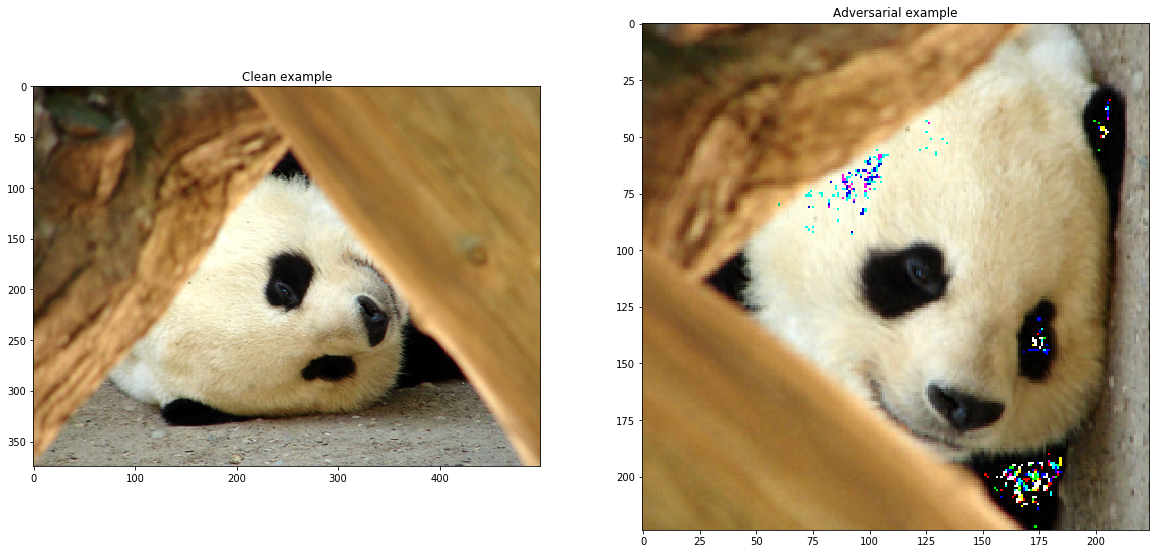

In [81]:
## Manual test: Tune the epsilon to see the effect on the adversarial example.
epsilon = 0.02


## Generate test data
filename = download_image(4)

image_as_tensor = image_to_tensor(filename)

label = "Giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca"
gradient, _, _ = predict(model, image_as_tensor, label, return_grad=True, supress_output=False)

print("\n==============================\nPerturbed image: \n")

## Predict with adversarial image
perturbed_data = generate_adversarial_fgsm(image_as_tensor, epsilon, gradient)

predict(model, perturbed_data, label, supress_output=False)


## Plots
# Clean example
## TODO: Decide if to use cropepd image
plt.subplot(1, 2, 1)
image = Image.open(filename)
plt.title("Clean example")
plt.imshow(image)

# Adversarial example
plt.subplot(1, 2, 2)
image_adversarial = tensor_to_image(perturbed_data)
plt.title("Adversarial example")
plt.imshow(image_adversarial)
plt.show()

In [62]:
## Generate examples so they can be used. Use pandas only.
indices = np.arange(3, 100)

filenames = []

for idx in indices:
    print(idx)
    f = download_image(idx)
    filenames.append(f)
    
    print(f)

print("Available images: " + str(len(filenames)))

3
./data/ImageNet/panda/Image_3.jpg
4
./data/ImageNet/panda/Image_4.jpg
5


HTTPError: HTTP Error 404: Not Found

In [48]:
## Iterate over maybe 1000 images
epsilons = [0.01, 0.1, 0.5]


accuracy = []
confidence = []

accuracy_adversarial = []
confidence_adversarial = []

for epsilon in epsilons:
    
    acc_sub = []
    conf_sub = []
    acc_sub_adver = []
    conf_sub_adver = []
    
    for filename in filenames:
        image_as_tensor = image_to_tensor(filename)

        label = ""
        gradient, acc, conf = predict(model, image_as_tensor, label, return_grad=True)
        acc_sub.append(acc)
        conf_sub.append(conf)

        ## Predict with adversarial image
        perturbed_data = generate_adversarial_fgsm(image_as_tensor, epsilon, gradient)
        _, acc, conf = predict(model, perturbed_data, label)
        acc_sub_adver.append(acc)
        conf_sub_adver.append(conf)
        
    ## Add accuracies and confidences
    accuracy.append(np.mean(acc_sub))
    confidence.append(np.mean(conf_sub))

    accuracy_adversarial.append(np.mean(acc_sub_adver))
    confidence_adversarial.append(np.mean(conf_sub_adver))
    
    
    
## Plot over epsilon: accuracy and confidence over maybe 1000 images

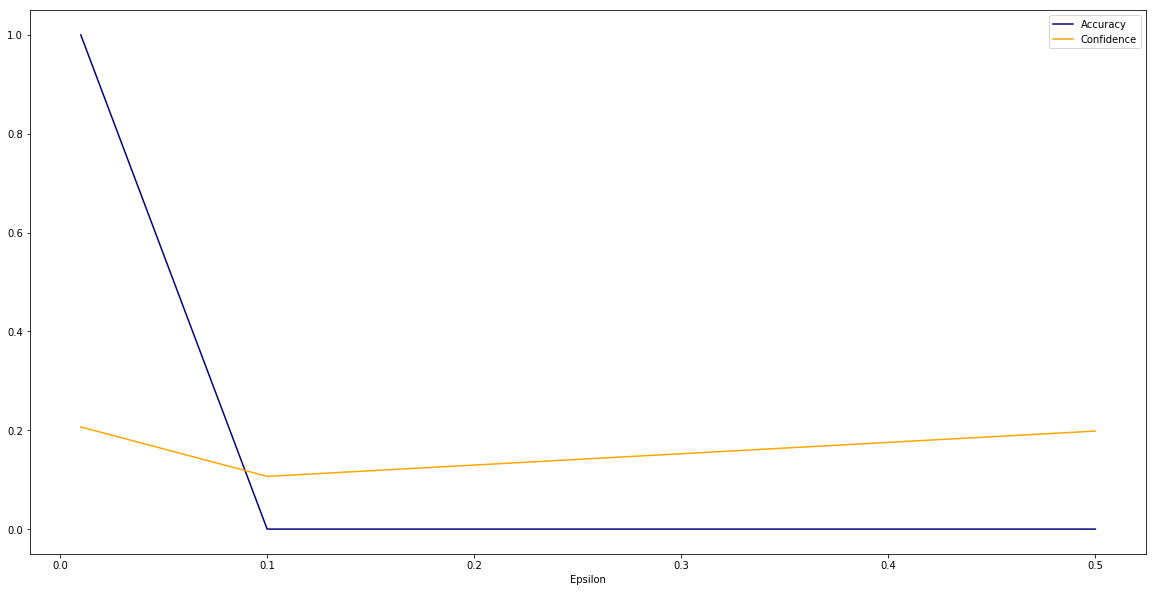

In [59]:
plt.plot(epsilons, accuracy_adversarial, color="navy", label="Accuracy")
plt.plot(epsilons, confidence_adversarial, color="orange", label="Confidence")
plt.xlabel("Epsilon")

plt.legend()
plt.show()

## 5. Conclusions

Some text...


## References

[1] Ian J. Goodfellow, Jonathon Shlens, Christian Szegedy. *Explaining and Harnessing Adversarial Examples*, 2015

[2] Szegedy et al. *Going Deeper with Convolutions*, 2015

[3] Deng, J. and Dong, W. and Socher, R. and Li, L.-J. and Li, K. and Fei-Fei, L. *ImageNet: A Large-Scale Hierarchical Image Database*, 2009